In [3]:
import torch
import scipy.signal as signal
import numpy as np
from matplotlib import pyplot as plt
import time
from torch2trt import TRTModule
from torch2trt import torch2trt
from models.CNN import ErnNet
from utils import get_pytorch_model

In [5]:
def get_start_points_x(width, slice_width, overlap_x):
    x_points = [0]
    stride = int(slice_width * (1 - overlap_x))
    counter = 1
    while True:
        pt = stride * counter
        if pt + slice_width >= width:
            x_points.append(width - slice_width)
            break
        else:
            x_points.append(pt)
        counter += 1
    return x_points

def get_total_inference_time(self, model, num_loops):
    """Returns the total inference time on all the loops"""
    # Wait for all kernels in all streams on the CUDA device to complete.
    torch.cuda.current_stream().synchronize()

    # GPU warmup
    for _ in range(10):
        _ = model(self.input_data_batch)

    t0 = time.time()
    for _ in range(num_loops):
        _ = model(self.input_data_batch)
        torch.cuda.current_stream().synchronize()
    t1 = time.time()

    return t1 - t0

In [6]:
# Load model
model_trt = TRTModule()
model_trt.load_state_dict(torch.load('trt_models/model_trt_int8.pth'))

<All keys matched successfully>

In [84]:
fs = 714 # Sampling frequency
nperseg = 128 # Length of each segment
noverlap = 64 # Number of overlapping points between segments
nfft = 128 # Length of FFT
dwell_time = 4
num_points = np.int64(np.floor(dwell_time* fs))
print(num_points)

# Remember what Robert said about 64 and 32 when creating arrays

x = np.random.random(num_points) + np.random.random(num_points) * 1j

f, t, Zxx = signal.stft(x, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=False, axis=- 1)
# plt.pcolormesh(t, f, np.abs(Zxx))

fft_dB =20*np.log10(np.abs(Zxx))

fft_dB.shape

2856


(128, 45)

In [81]:
714*45

32130

In [78]:
# Check to see how the stft function is working
x = torch.randn(2,num_points, dtype=torch.cfloat)
x0 = x[0]
x1 = x[1]

f, t, Zxx = signal.stft(x, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=False, axis=- 1)

t0 = time.time()
f, t, Zxx = signal.stft(x, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=False, axis=- 1)

t1 = time.time()
f, t, Zxx0 = signal.stft(x0, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=False, axis=- 1)

t2 = time.time()
f, t, Zxx1 = signal.stft(x1, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=False, axis=- 1)

t3 = time.time()

if np.array_equal(Zxx[0], Zxx0) and np.array_equal(Zxx[1],Zxx1):
    print('Equal')

print(t1-t0)
print(t2-t1)
print(t3-t2)

Equal
0.0005512237548828125
0.0004677772521972656
0.0004417896270751953


0.0004565715789794922
0.0003662109375
0.0003800392150878906


In [35]:
if np.array_equal(Zxx[0], Zxx0) and np.array_equal(Zxx[1],Zxx1):
    print('Equal')


Equal


In [79]:
x = torch.randn(40000,num_points, dtype=torch.cfloat)
print(len(x))

# Get the short-term fourier transform of the signal
f, t, Zxx = signal.stft(x, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=False, axis=- 1)
# plt.pcolormesh(t, f, np.abs(Zxx))

Zxx_tensor = torch.from_numpy(Zxx)

# print(type(Zxx))
# # Converting to dB
# Zxx_tensor = torch.from_numpy(Zxx)
# fft_dB = 20*torch.log10(torch.abs(Zxx_tensor))
# # fft_dB.shape

# width = fft_dB.shape[1]
# fft_dB.shape


Zxx_tensor = torch.from_numpy(Zxx)

# Zxx = torch.randn(128,45)

# Converting to dB
fft_dB = 20*torch.log10(torch.abs(Zxx_tensor))
_ = model_trt(fft_dB.cuda())

40000


In [59]:
num_points

2856

In [8]:
num_range_bins = 36000
fs = 714 # Sampling frequency
nperseg = 128 # Length of each segment
noverlap = 64 # Number of overlapping points between segments
nfft = 128 # Length of FFT
dwell_time = 4
slice_width = 45
overlap = 0.5
num_points = np.int64(np.floor(dwell_time* fs))
classified_imgs = 0
num_loops = 10
times = []
num_range_bins_array = np.arange(10000, 50000, 5000)

torch.cuda.current_stream().synchronize()
# GPU warmup
for _ in range(100):
    _ = model_trt(torch.randn((1, 1, 128, 45)).cuda())

for num_range_bins in num_range_bins_array:
    # Start counter
    range_bin_times = []
    t0 = time.time()

    for _ in range(num_loops):
        # Creating the samples
        t2 = time.time()
        x = torch.randn(num_range_bins, num_points, dtype=torch.cfloat)

        # Get the short-term fourier transform of the signal

        f, t, Zxx = signal.stft(x, fs=fs, window='hamming', nperseg=nperseg, 
                                noverlap=noverlap, nfft=nfft, detrend=False, 
                                return_onesided=False, axis=-1)

        Zxx_tensor = torch.from_numpy(Zxx)
        # Zxx_tensor = torch.randn(128,45)

        # Converting to dB
        fft_dB = 20*torch.log10(torch.abs(Zxx_tensor))
        _ = model_trt(fft_dB.cuda())

        t3 = time.time()

        range_bin_times.append (t3-t2)

    times.append((range_bin_times))



/home/nyasha/anaconda3/envs/thesis/lib/python3.8/site-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


In [18]:
num_range_bins_array = np.arange(10000, 45000, 5000)

[Text(1, 0, '10000'),
 Text(2, 0, '15000'),
 Text(3, 0, '20000'),
 Text(4, 0, '25000'),
 Text(5, 0, '30000'),
 Text(6, 0, '35000'),
 Text(7, 0, '40000')]

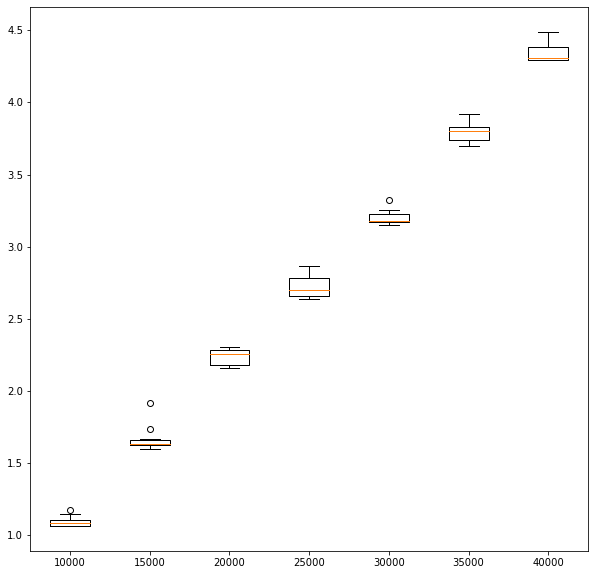

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(times)
ax.set_xticklabels(num_range_bins_array)

In [12]:
# On cpu
# On gpu
# On cpu with parallelisation

# Show the throttling of the stft function
# Review decision in padded=false
#

5500

In [21]:
# In parallel

num_range_bins = 36000
fs = 714 # Sampling frequency
nperseg = 128 # Length of each segment
noverlap = 64 # Number of overlapping points between segments
nfft = 128 # Length of FFT
dwell_time = 4
slice_width = 45
overlap = 0.5
num_points = np.int64(np.floor(dwell_time* fs))
classified_imgs = 0
num_loops = 10
times = []
num_range_bins_array = np.arange(10000, 50000, 5000)

torch.cuda.current_stream().synchronize()
# GPU warmup
for _ in range(100):
    _ = model_trt(torch.randn((1, 1, 128, 45)).cuda())

for num_range_bins in num_range_bins_array:
    # Start counter
    range_bin_times = []
    t0 = time.time()

    for _ in range(num_loops):
        # Creating the samples
        t2 = time.time()
        x = torch.randn(num_range_bins, num_points, dtype=torch.cfloat)

        # Get the short-term fourier transform of the signal

        # f, t, Zxx = signal.stft(x, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=False, axis=-1)
        # Zxx_tensor = torch.from_numpy(Zxx)
        Zxx_tensor = torch.randn(128,45)

        # Converting to dB
        fft_dB = 20*torch.log10(torch.abs(Zxx_tensor))
        _ = model_trt(fft_dB.cuda())

        t3 = time.time()

        range_bin_times.append (t3-t2)

    times.append((range_bin_times))



RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [21]:
throughput = num_imgs/(t1-t0)
point_throughput = throughput * slice_width
supported_range_bins = point_throughput/fs
supported_range_bins*5

1969.864781229934